In [1]:
# Pagrindinės bibliotekos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Vizualizacijai, atkreipkite dėmesį, kad naudojame "matplotlib" pagrindu
import warnings
import requests
from datetime import datetime
from bs4 import BeautifulSoup
import time
import sqlite3

# Duomenų modeliavimas ir analizė
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Darbas su interneto naršyklėmis per Selenium
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

# Įspėjimų ignoravimas
warnings.filterwarnings('ignore')

# Specializuoti moduliai
from numpy.polynomial import Polynomial

import json
from sklearn.preprocessing import StandardScaler
from datetime import timedelta

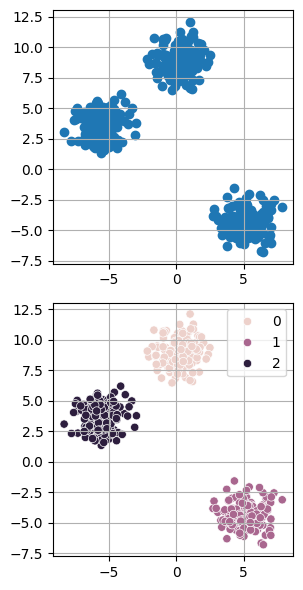

In [2]:
# Klasterizavimas su scikit-learn 
# k-Means 

from sklearn.datasets import make_blobs
X,y = make_blobs(n_samples = 500,n_features = 2,centers = 3,random_state = 23)
fig, (axis, ax) = plt.subplots(2, gridspec_kw={'height_ratios':[1,1]}, figsize=[3,6])
axis.grid(True)
axis.scatter(X[:,0], X[:,1])
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, ax=ax)
ax.grid(True)
fig.tight_layout()
plt.show()


In [3]:
from sklearn.cluster import KMeans

In [4]:
kmeans = KMeans(n_clusters=3)
predicted_labels = kmeans.fit_predict(X)

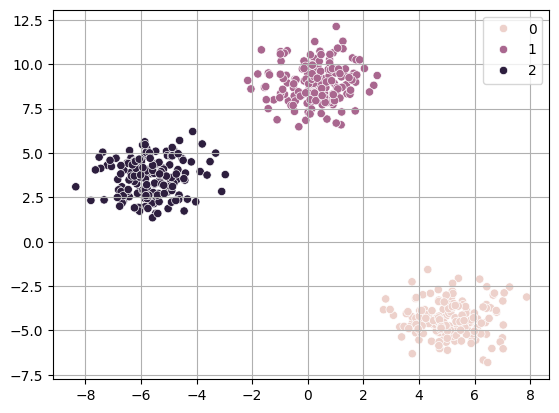

In [5]:
ax = sns.scatterplot(x=X[:,0], y=X[:,1], hue=predicted_labels)
ax.grid(True)
plt.show()

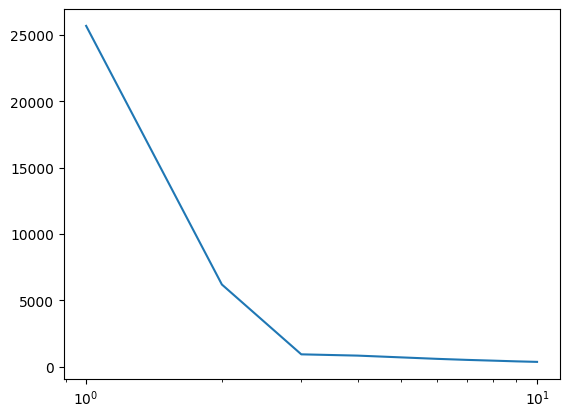

In [6]:
# Teisingo klasterio skaiciaus nustatymas
sse = []
for k in range(1, 11):
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)

ax = sns.lineplot(x=range(1, 11), y=sse)
ax.set(xscale="log")
plt.show()


In [7]:
#  Aruodas skelbimai
# Į kiek klasterių galima suskirstyti Vilniuje esančius sklebimus?
# X - features yra skelbimo koordinatės
# Ar galite suskaičiuoti kiekviename klasteryje esančią vidutinę būsto kainą?
# ?Atvaizduokite duoenis su mapbox()

In [25]:
conn = sqlite3.connect('aruodas3.db')
df = pd.read_sql_query("SELECT * FROM aruododuomenys", conn)
df = df[df['miestas'] == 'Vilnius']
df = df[['ilguma', 'platuma']]
df = df.dropna(subset=['ilguma', 'platuma'])
df

,ilguma,platuma
0,54.701257,25.272667
1,54.705467,25.286944
2,54.717923,25.238122
3,54.691637,25.284638
4,54.707286,25.286241
...,...,...
3084,54.682515,25.220766
3085,54.710757,25.287010
3086,54.700492,25.307491
3087,54.714199,25.313860


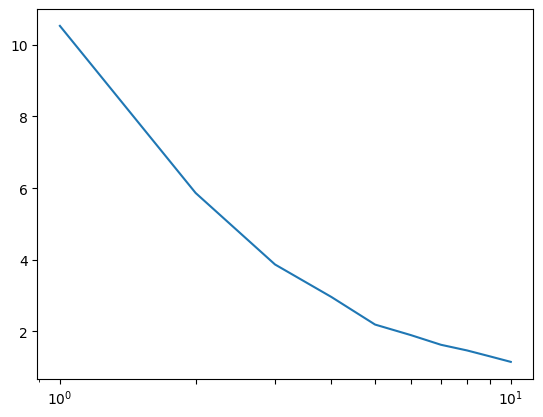

In [26]:
sse = []
for k in range(1, 11):
    km = KMeans(n_clusters=k)
    km.fit(df)
    sse.append(km.inertia_)

ax = sns.lineplot(x=range(1, 11), y=sse)
ax.set(xscale="log")
plt.xticks(range(1, 11))
plt.show()



In [34]:
results_df = pd.DataFrame({'Cluster Count': range(1, 11), 'SSE': sse})
results_df
results_df['SSE %'] = results_df['SSE'].pct_change() * 100
results_df

,Cluster Count,SSE,SSE %
0,1,10.529786,NaN
1,2,5.864665,-44.304041
2,3,3.868061,-34.044648
3,4,2.961184,-23.445246
4,5,2.190687,-26.019913
5,6,1.897239,-13.395262
6,7,1.626318,-14.279717
7,8,1.467835,-9.744920
8,9,1.300970,-11.368102
9,10,1.148941,-11.685788


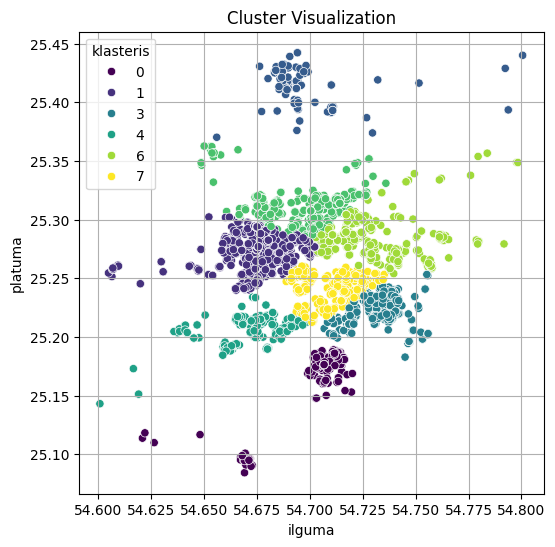

In [35]:
kmeans = KMeans(n_clusters=8, random_state=23)
df['klasteris'] = kmeans.fit_predict(df[['ilguma', 'platuma']])

# Plotting the clusters
plt.figure(figsize=[6, 6])
sns.scatterplot(x='ilguma', y='platuma', hue='klasteris', data=df, palette='viridis')
plt.title('Cluster Visualization')
plt.grid(True)
plt.show()

In [36]:
df

,ilguma,platuma,klasteris
0,54.701257,25.272667,1
1,54.705467,25.286944,6
2,54.717923,25.238122,7
3,54.691637,25.284638,1
4,54.707286,25.286241,6
...,...,...,...
3084,54.682515,25.220766,4
3085,54.710757,25.287010,6
3086,54.700492,25.307491,5
3087,54.714199,25.313860,5


In [37]:
import plotly.express as px

fig = px.scatter_mapbox(df, lat='ilguma', lon='platuma', color='klasteris', mapbox_style="open-street-map")
fig.show()

In [ ]:
# GridSearchCV 

